In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation
import tensorflow_addons as tfa

In [34]:
from kaggle_secrets import UserSecretsClient
import wandb
from wandb.keras import WandbCallback
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret('wandb-api-key')
wandb.login(key = wandb_api)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [35]:
train_directory = '../input/plant-pathology-2021-fgvc8/train_images'
test_directory = '../input/plant-pathology-2021-fgvc8/test_images'

In [36]:
train_data = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
train_data.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [37]:
train_data.labels.value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


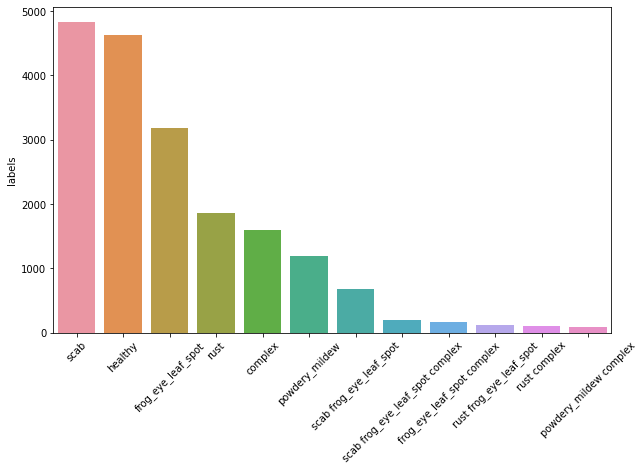

In [38]:
plt.figure(figsize=(10, 6))
labels = sns.barplot(train_data.labels.value_counts().index, train_data.labels.value_counts())
for i in labels.get_xticklabels():
    i.set_rotation(45)

In [39]:
train_data.labels = train_data.labels.apply(lambda s: s.split(' '))

In [40]:
list_of_labels = list(train_data.labels)
mlb = MultiLabelBinarizer()
label_dataframe = pd.DataFrame(mlb.fit_transform(list_of_labels), columns=mlb.classes_, index=train_data.index)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

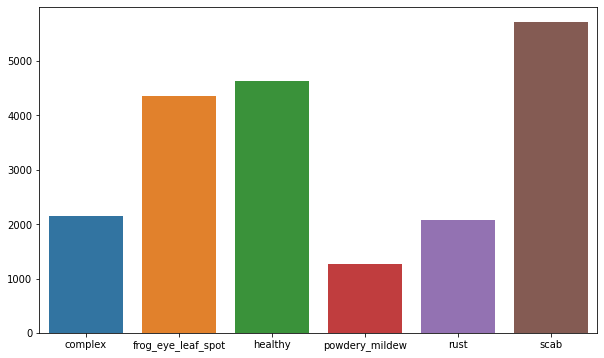

In [41]:
labels = list(label_dataframe.sum().keys())
label_counts = label_dataframe.sum().values.tolist()
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(labels, label_counts, ax=axes)

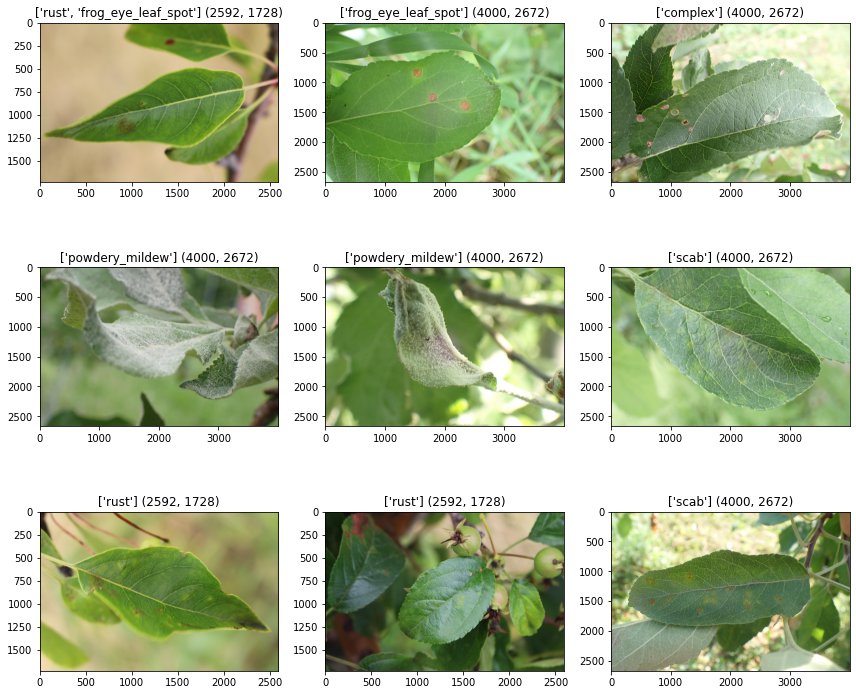

In [42]:
fig1 = plt.figure(figsize=(12, 12))
for i in range(1, 10):
    random_number = random.randrange(1, 18000)
    sample_image = os.path.join('../input/plant-pathology-2021-fgvc8/train_images/', train_data.image[random_number])
    img = PIL.Image.open(sample_image)
    ax = fig1.add_subplot(3, 3, i)
    ax.imshow(img)
    title = f'{train_data.labels[random_number]} {img.size}'
    plt.title(title)
    fig1.tight_layout()

In [43]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = None,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split= 0.15
)

In [44]:
X_COL = 'image'
Y_COL = 'labels'
COLOR_MODE = 'rgb'
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TARGET_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
TARGET_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
CLASS_MODE = 'categorical'
BSIZE = 16

In [45]:
training_set = datagen.flow_from_dataframe(
    train_data,
    directory = '../input/resized-plant2021/img_sz_512',
    x_col = X_COL,
    y_col = Y_COL,
    subset = 'training',
    color_mode = COLOR_MODE,
    target_size = TARGET_SIZE,
    class_mode = CLASS_MODE,
    batch_size = BSIZE,
    shuffle = False,
    seed = 40
)

Found 15838 validated image filenames belonging to 6 classes.


In [46]:
validation_set = datagen.flow_from_dataframe(
    train_data,
    directory = '../input/resized-plant2021/img_sz_512',
    x_col = X_COL,
    y_col = Y_COL,
    subset = 'validation',
    color_mode = COLOR_MODE,
    target_size = TARGET_SIZE,
    class_mode = CLASS_MODE,
    batch_size = BSIZE,
    shuffle = False,
    seed = 40
)

Found 2794 validated image filenames belonging to 6 classes.


In [48]:
alexNet = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=TARGET_SHAPE),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')
])

threshold = 0.25
optimizer = tf.keras.optimizers.Adam()
f1 = tfa.metrics.F1Score(num_classes=6, average='macro', threshold=threshold)

In [49]:
checkpoint_path = 'training/alexNet-{epoch:04d}.ckpt'

In [50]:
learningrate_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', fator=0.05, patience=5, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor=f1, patience=3, mode='max', restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, save_freq='epoch')

In [51]:
CONFIG = dict (
    num_labels = 6,
    train_val_split = 0.15,
    img_width = IMAGE_WIDTH,
    img_height = IMAGE_HEIGHT,
    batch_size = BSIZE,
    epochs = 15,
    learning_rate = 0.001,
    architecture = "CNN",
    infra = "Kaggle",
    model_name = "alexNet"
)
print('Training Configuration: ', CONFIG)
run = wandb.init(project='plant_pathology_2021', config=CONFIG, group='alexNet', job_type='train')
callbacks_list = [early_stopping, learningrate_scheduler, checkpoint_callback, WandbCallback()]

Training Configuration:  {'num_labels': 6, 'train_val_split': 0.15, 'img_width': 224, 'img_height': 224, 'batch_size': 16, 'epochs': 15, 'learning_rate': 0.001, 'architecture': 'CNN', 'infra': 'Kaggle', 'model_name': 'alexNet'}


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [52]:
wandb.config.type = 'baseline'
wandb.config.kaggle_competition = 'Plant Pathology 2021 - FGVC8'

In [55]:
alexNet.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=[f1])

In [57]:
history = alexNet.fit(training_set, validation_data=validation_set, callbacks=callbacks_list, epochs=15)
run.finish()

Epoch 1/15
990/990 [==============================] - 373s 369ms/step - loss: 1.3152 - f1_score: 0.2704 - val_loss: 0.4702 - val_f1_score: 0.2502

Epoch 00001: saving model to training/alexNet-0001.ckpt
Epoch 2/15
990/990 [==============================] - 246s 249ms/step - loss: 0.4519 - f1_score: 0.3302 - val_loss: 0.4227 - val_f1_score: 0.2946

Epoch 00002: saving model to training/alexNet-0002.ckpt
Epoch 3/15
990/990 [==============================] - 244s 247ms/step - loss: 0.4425 - f1_score: 0.3282 - val_loss: 0.4476 - val_f1_score: 0.1801

Epoch 00003: saving model to training/alexNet-0003.ckpt
Epoch 4/15
990/990 [==============================] - 244s 247ms/step - loss: 0.4369 - f1_score: 0.3242 - val_loss: 0.4058 - val_f1_score: 0.3818

Epoch 00004: saving model to training/alexNet-0004.ckpt
Epoch 5/15
990/990 [==============================] - 250s 252ms/step - loss: 0.4285 - f1_score: 0.3509 - val_loss: 0.4373 - val_f1_score: 0.2219

Epoch 00005: saving model to training/ale

epoch,14
loss,0.19659
f1_score,0.75431
val_loss,0.18634
val_f1_score,0.77316
lr,0.0001
_runtime,4141
_timestamp,1630185401
_step,14
best_val_loss,0.18534
best_epoch,13


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▅▄▄▄▃▃▂▂▁▁▁▁▁
f1_score,▁▂▂▂▂▂▄▅▆▇█████
val_loss,▆▅▅▅▅▅██▅▂▂▁▁▁▁
val_f1_score,▂▂▁▃▁▂▂▃▃█▇████
lr,█████████▁▁▁▁▁▁
_runtime,▁▂▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


In [60]:
base_efficientNetB7 = tf.keras.applications.EfficientNetB7(input_shape=TARGET_SHAPE, include_top=False, weights='imagenet')
X = base_efficientNetB7.output
X = GlobalAveragePooling2D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dense(16, activation='relu')(X)
predictions = tf.keras.layers.Dense(6, activation='sigmoid')(X)

258080768/258076736 [==============================] - 2s 0us/step


In [61]:
efficientNet = tf.keras.Model(inputs=base_efficientNetB7.input, outputs=predictions)

In [62]:
checkpoint_path = 'training/efficientNet-{epoch:04d}.ckpt'

In [63]:
CONFIG = dict (
    num_labels = 6,
    train_val_split = 0.15,
    img_width = IMAGE_WIDTH,
    img_height = IMAGE_HEIGHT,
    batch_size = BSIZE,
    epochs = 15,
    learning_rate = 0.001,
    architecture = "CNN",
    infra = "Kaggle",
    model_name = "efficientNet"
)
print('Training Configuration: ', CONFIG)
run = wandb.init(project='plant_pathology_2021', config=CONFIG, group='efficientNet', job_type='train')
callbacks_list = [early_stopping, learningrate_scheduler, checkpoint_callback, WandbCallback()]

Training Configuration:  {'num_labels': 6, 'train_val_split': 0.15, 'img_width': 224, 'img_height': 224, 'batch_size': 16, 'epochs': 15, 'learning_rate': 0.001, 'architecture': 'CNN', 'infra': 'Kaggle', 'model_name': 'efficientNet'}


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [64]:
efficientNet.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=[f1])

In [65]:
history = efficientNet.fit(training_set, validation_data=validation_set, callbacks=callbacks_list, epochs=15)
run.finish()

Epoch 1/15
990/990 [==============================] - 698s 676ms/step - loss: 0.2829 - f1_score: 0.6641 - val_loss: 0.1077 - val_f1_score: 0.8665

Epoch 00001: saving model to training/alexNet-0001.ckpt
Epoch 2/15
990/990 [==============================] - 664s 671ms/step - loss: 0.1147 - f1_score: 0.8510 - val_loss: 0.0949 - val_f1_score: 0.8734

Epoch 00002: saving model to training/alexNet-0002.ckpt
Epoch 3/15
990/990 [==============================] - 664s 670ms/step - loss: 0.0883 - f1_score: 0.8838 - val_loss: 0.0867 - val_f1_score: 0.8902

Epoch 00003: saving model to training/alexNet-0003.ckpt
Epoch 4/15
990/990 [==============================] - 666s 672ms/step - loss: 0.0756 - f1_score: 0.8988 - val_loss: 0.0859 - val_f1_score: 0.9003

Epoch 00004: saving model to training/alexNet-0004.ckpt
Epoch 5/15
990/990 [==============================] - 665s 671ms/step - loss: 0.0653 - f1_score: 0.9104 - val_loss: 0.0878 - val_f1_score: 0.8944

Epoch 00005: saving model to training/ale

epoch,14
loss,0.01018
f1_score,0.98685
val_loss,0.1059
val_f1_score,0.91322
lr,0.0
_runtime,10199
_timestamp,1630196342
_step,14
best_val_loss,0.08591
best_epoch,3


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▃▃▃▂▂▂▁▁▁▁▁▁
f1_score,▁▅▅▆▆▆▇▇▇██████
val_loss,▅▃▁▁▁▄█▃▃▂▂▄▅▅▅
val_f1_score,▁▂▄▆▅▃▃▅▅▇▇▇▇██
lr,█████████▂▂▂▂▂▁
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


In [86]:
alexNet.save('training/final_model2.h5')

In [67]:
submission = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')

In [69]:
pos = ImageDataGenerator(rescale = 1./255)
test_data = pos.flow_from_dataframe(
    submission,
    directory = '../input/plant-pathology-2021-fgvc8/test_images',
    x_col="image",
    y_col= "labels",
    color_mode="rgb",
    target_size = (224,224),
    classes=None,
    class_mode=None,
    batch_size=8,
    shuffle=False,
    seed=40,
)

Found 3 validated image filenames.


In [82]:
final_model = tf.keras.models.load_model('final_model.h5')
preds = efficientNet.predict(test_data).tolist()

indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=0.25:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)

print(indices)
print(labels)
labels = (training_set.class_indices)
labels = { v:k for k,v in labels.items() }
testlabels = []
for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

[[3], [3], [3]]
{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}


In [77]:
submission.labels = testlabels
submission.to_csv('submission.csv', index=False)